# Distributed Insights for LMS Logs Analysis

Data source: [Kaggle](https://www.kaggle.com/datasets/junyiacademy/learning-activity-public-dataset-by-junyi-academy)

 <a id='top'></a>
 # Contents:
 
 + [Data Overview](#overview)
 + [Aggregation and Labeling](#aggregation)
 + [Modeling and Vizualization](#modeling)

In [1]:
import sys
from typing import List, Tuple, Optional # type hints
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame # for type hints

# sql functions used in analysis
from pyspark.sql.functions import date_trunc, count, countDistinct, round, \
                                  min, max, avg, sum, when, lit, to_date, udf, concat

from pyspark.sql.types import StringType # for user-defined functions

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer # to vectorize data
from pyspark.ml.tuning import ParamGridBuilder # hyperparameter grid search
from pyspark.ml import Pipeline

# for cross-validation and model evaluation
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# lena spark cluster can't find pyplot unless we append this locale to path
sys.path.append("/usr/local/lib/python3.8/dist-packages")

import matplotlib.pyplot as plt
import datetime # interacting with sql datetime

<a id='overview'></a>
### Data Overview
[Back to top](#Top)

Some summary tables are produced, focusing on fields of interest. Binning is used to simplify summary of data, and informative crosstabulation is generated.

In [2]:
# a reusable function for summarizing features
def summary_tables(df: DataFrame, cols: Optional[List[str]], cross: Optional[List[Tuple[str, str]]]) -> None:
    
    # define all columns if none provided
    if not cols:
        cols = df.columns
    
    # overall summary stats
    df.describe(cols).show()
    
    print("Null and Value counts:")

    for col in cols:
        print(f"\n{col} - Null: {df.filter(df[col].isNull()).count()}\n") 
        df.groupBy(col).count().orderBy("count", ascending=False).show()
    
    print("Crosstabs")
    for cro in cross:
        print(f"{cro} - ")
        ct_name = cro[0] + "_" + cro[1]
        
        ct = df.crosstab(cro[0], cro[1])
        
        # crosstab in spark casts named column as string - check if we should recast
        if df.select(cro[0]).dtypes[0][1] == "int":
            ct = ct.withColumn(ct_name, ct[ct_name].cast("int"))
        
        ct.sort(ct_name).show()

In [3]:
# create spark session
spark = SparkSession.builder.appName("junyi_analysis").getOrCreate()

# read hdfs tabular data
logs = spark.read.csv("hdfs://lena/user/cshep001/Log_Problem.csv", header=True, inferSchema=True)

users = spark.read.csv("hdfs://lena/user/cshep001/Info_UserData.csv", header=True, inferSchema=True)

In [4]:
users.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- points: integer (nullable = true)
 |-- badges_cnt: integer (nullable = true)
 |-- first_login_date_TW: string (nullable = true)
 |-- user_grade: integer (nullable = true)
 |-- user_city: string (nullable = true)
 |-- has_teacher_cnt: integer (nullable = true)
 |-- is_self_coach: boolean (nullable = true)
 |-- has_student_cnt: integer (nullable = true)
 |-- belongs_to_class_cnt: integer (nullable = true)
 |-- has_class_cnt: integer (nullable = true)



#### Notes:

*We will create some bins to summarize data distribution for badge count and generate summary tables for columns of interest.*

In [5]:
def badges_binner(badges):
    if badges == 0:
        return "none"
    if badges == 1:
        return "one"
    if badges > 1:
        return "multiple"

In [6]:
user_cols = ["gender",
             "points",
             "badges_cnt",
             "has_teacher_cnt",
             "user_grade"]

user_cross_cols = [("user_grade", "badges_cnt_bin"),
                   ]

bucket_badges = udf(badges_binner, StringType())
bin_summary_tables = users.withColumn("badges_cnt_bin", bucket_badges("badges_cnt"))

summary_tables(bin_summary_tables, user_cols, user_cross_cols)

+-------+-----------+------------------+------------------+------------------+------------------+
|summary|     gender|            points|        badges_cnt|   has_teacher_cnt|        user_grade|
+-------+-----------+------------------+------------------+------------------+------------------+
|  count|      32905|             72758|             72758|             72758|             72758|
|   mean|       null| 63047.58562632288|  9.54378899914786|0.8848099178097254|5.6207152478078015|
| stddev|       null|124204.18531345883|19.036328198505878| 1.552794681417299| 2.041177791970549|
|    min|     female|                 1|                 0|                 0|                 1|
|    max|unspecified|           4047528|               760|               106|                12|
+-------+-----------+------------------+------------------+------------------+------------------+

Null and Value counts:

gender - Null: 39853

+-----------+-----+
|     gender|count|
+-----------+-----+
|       nul

In [8]:
# make binned crosstab with percentages
ct = bin_summary_tables.crosstab("user_grade", "badges_cnt_bin")

ct = ct.withColumn("No badges %", round(ct.none / (ct.one + ct.multiple + ct.none), 2))\
       .withColumn("one %", round(ct.one / (ct.one + ct.multiple + ct.none), 2))\
       .withColumn("multiple %", round(ct.multiple / (ct.one + ct.multiple + ct.none), 2))

ct.sort("user_grade_badges_cnt_bin").show()

+-------------------------+--------+----+----+-----------+-----+----------+
|user_grade_badges_cnt_bin|multiple|none| one|No badges %|one %|multiple %|
+-------------------------+--------+----+----+-----------+-----+----------+
|                        1|     753| 369| 266|       0.27| 0.19|      0.54|
|                       10|     567| 363| 138|       0.34| 0.13|      0.53|
|                       11|     322| 178|  70|       0.31| 0.12|      0.56|
|                       12|     292| 173|  59|       0.33| 0.11|      0.56|
|                        2|    1098| 396| 321|       0.22| 0.18|       0.6|
|                        3|    4447|2661|1216|       0.32| 0.15|      0.53|
|                        4|    5196|3185|1671|       0.32| 0.17|      0.52|
|                        5|    9331|3388|2001|       0.23| 0.14|      0.63|
|                        6|    6891|3151|1526|       0.27| 0.13|       0.6|
|                        7|    7615|3503|1642|       0.27| 0.13|       0.6|
|           

#### Notes:

*Because of the large number of null values seen in gender, we'll discard this in furhter analysis.*

In [9]:
logs.printSchema()

root
 |-- timestamp_TW: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- ucid: string (nullable = true)
 |-- upid: string (nullable = true)
 |-- problem_number: integer (nullable = true)
 |-- exercise_problem_repeat_session: integer (nullable = true)
 |-- is_correct: boolean (nullable = true)
 |-- total_sec_taken: integer (nullable = true)
 |-- total_attempt_cnt: integer (nullable = true)
 |-- used_hint_cnt: integer (nullable = true)
 |-- is_hint_used: boolean (nullable = true)
 |-- is_downgrade: boolean (nullable = true)
 |-- is_upgrade: boolean (nullable = true)
 |-- level: integer (nullable = true)



In [10]:
logs.describe(["level"]).show()

+-------+-------------------+
|summary|              level|
+-------+-------------------+
|  count|           16217311|
|   mean|0.48279902876623626|
| stddev| 0.9370259293337498|
|    min|                  0|
|    max|                  4|
+-------+-------------------+



In [11]:
logs.groupBy("level").count().orderBy("count", ascending=False).show()

+-----+--------+
|level|   count|
+-----+--------+
|    0|11809119|
|    1| 2352668|
|    2|  996819|
|    3|  751424|
|    4|  307281|
+-----+--------+



In [12]:
# create a uid for level and problem number
logs = logs.withColumn("lvl_question", concat(logs.level, logs.problem_number))

# add an average time per question and use it to standardize attempt 
logs_normal = logs.groupBy("lvl_question").agg(
                    avg(logs.total_sec_taken).alias("avg_question")).join(logs, ["lvl_question"])
    
logs = logs_normal.withColumn("attempt_timing", (logs_normal.total_sec_taken / logs_normal.avg_question))

In [13]:
def seconds_binner(seconds: float) -> str:
    try:
        if seconds == 0.00:
            return " 0 time taken"
        if seconds < 0.26 :
            return " 25% or less"
        if (seconds >= 0.26) and (seconds < 0.51):
            return " 26 - 50%"
        if (seconds >= 0.51) and (seconds < 0.76):
            return " 51 - 75%"
        if (seconds >= 0.76) and (seconds < 1.01):
            return " 76 - 100%"
        if (seconds >= 1.01) and (seconds < 1.26):
            return "101 - 125%"
        if (seconds >= 1.26) and (seconds < 1.51):
            return "126 - 150%"
        if (seconds >= 1.51) and (seconds < 1.76):
            return "151 - 175%"
        if (seconds >= 1.76) and (seconds < 2.01):
            return "176 - 200%"
        else:
            return "more than 200%"
    except TypeError:
        return seconds

In [14]:
cols = ["exercise_problem_repeat_session",
        "is_correct",
        "total_sec_taken",
        "used_hint_cnt",
        "level",
        "attempt_timing"]

cross_cols = [("seconds_taken_bin", "is_correct"),
              ("used_hint_cnt", "is_correct")]

bucket_sec_taken = udf(seconds_binner, StringType())
bin_summary_tables = logs.withColumn("seconds_taken_bin", bucket_sec_taken("attempt_timing"))

summary_tables(bin_summary_tables, cols, cross_cols)

+-------+-------------------------------+------------------+------------------+-------------------+------------------+
|summary|exercise_problem_repeat_session|   total_sec_taken|     used_hint_cnt|              level|    attempt_timing|
+-------+-------------------------------+------------------+------------------+-------------------+------------------+
|  count|                       16217311|          16217311|          16217311|           16217311|          16217310|
|   mean|               1.26121827471891| 44.38166093010118|0.5333163432581394|0.48279902876623626|1.0000000000001599|
| stddev|             1.1734843912692965|100.53747000121683|1.1569170448469774|  0.937025929333749|2.2898490516792416|
|    min|                              1|                 0|                 0|                  0|               0.0|
|    max|                            119|              1800|                65|                  4| 95.05675349050482|
+-------+-------------------------------+-------

KeyboardInterrupt: 

#### Notes:

*It looks like there are some discernable connections between the normalized amount of time it takes for a question to be completed and accuracy. Let's confirm this with a reformulated crosstab with percents.*

In [ ]:
ct = bin_summary_tables.crosstab("seconds_taken_bin", "is_correct")

ct = ct.withColumn("false %", round(ct.false / (ct.false + ct.true), 2)).withColumn("true %", round(ct.true / (ct.false + ct.true), 2))

ct.sort("seconds_taken_bin_is_correct").show()

<a id="aggregation"></a>
### Aggregation and Labeling
[Back to top](#top)

In order to address hypothesis about differences in grade level approaches, we will join user and log data and label users based on if they return to the platform acroos multiple days. We will then attempt to use a random forest classifier to determine what are important factors in influencing returning students across different levels. We include a filter for students that joined later in the window of time where data is available as their returning may not have been recorded.

In [15]:
logs.printSchema()

root
 |-- lvl_question: string (nullable = true)
 |-- avg_question: double (nullable = true)
 |-- timestamp_TW: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- ucid: string (nullable = true)
 |-- upid: string (nullable = true)
 |-- problem_number: integer (nullable = true)
 |-- exercise_problem_repeat_session: integer (nullable = true)
 |-- is_correct: boolean (nullable = true)
 |-- total_sec_taken: integer (nullable = true)
 |-- total_attempt_cnt: integer (nullable = true)
 |-- used_hint_cnt: integer (nullable = true)
 |-- is_hint_used: boolean (nullable = true)
 |-- is_downgrade: boolean (nullable = true)
 |-- is_upgrade: boolean (nullable = true)
 |-- level: integer (nullable = true)
 |-- attempt_timing: double (nullable = true)



In [16]:
# a function to join logs and user tables creating specified aggregations
def join_to_users(logs: DataFrame, user_data: DataFrame, level: int=None) -> DataFrame:
    
    # filter by level if specified
    if level:
        logs = logs.filter(logs.level==level)
    
    # join logs to user data
    joined = logs.groupBy("uuid").agg(
                    countDistinct(date_trunc("day", logs.timestamp_TW)).alias("days"),
                    to_date(max(logs.timestamp_TW)).alias("max_date"),
                    to_date(min(logs.timestamp_TW)).alias("min_date"),
                    (sum(logs.used_hint_cnt) / count(logs.timestamp_TW)).alias("avg_hints"),
                    avg(logs.total_sec_taken).alias("avg_seconds_take"),
                    avg(logs.total_attempt_cnt).alias("avg_attempts"),
                    avg(logs.exercise_problem_repeat_session).alias("avg_repeated_sessions"),
                    (count(logs.is_correct) / count(logs.timestamp_TW)).alias("avg_correct_answers"),
                    avg(logs.attempt_timing).alias("avg_timing"))\
                    .join(users, ["uuid"])
    
    # ignore users who first joined less than 3 months before the end of available data
    filtered = joined.filter(joined.min_date < datetime.date(2019, 6, 30))
    
    # apply labels to students returning 5 or more distinct days, 2-4 distinct days, or just 1 day
    labeled = filtered.withColumn("label",
                     when((filtered.days > 4), lit(3)).
                     when((filtered.days < 5) & (
                         filtered.days > 1), lit(2)).
                     otherwise(lit(0)))
    
    return labeled

In [17]:
# level-segmented joins
level_0 = join_to_users(logs, users, 0)
level_1 = join_to_users(logs, users, 1)
level_2 = join_to_users(logs, users, 2)
level_3 = join_to_users(logs, users, 3)
level_4 = join_to_users(logs, users, 4)
all_levels = join_to_users(logs, users)

<a id="modeling"></a>
### Modeling and Visualisation
[Back to top](#top)

A set of features of interest is defined, as well as model training and evaluation functions. Models for various levels are created using a random forest classifier and crossvalidation with a grid search. Parameters are limited here to reduce run time. 

In [18]:
features = ["label", 
            "avg_hints", 
            "avg_timing",
            "avg_repeated_sessions"]

In [19]:
all_levels[features].printSchema()

root
 |-- label: integer (nullable = false)
 |-- avg_hints: double (nullable = true)
 |-- avg_timing: double (nullable = true)
 |-- avg_repeated_sessions: double (nullable = true)



In [20]:
def train_model(data: DataFrame):
    
    # define a feature list seperate from labels
    feature_list = []
    for col in data.columns:
        if col == "label":
            continue
        else:
            feature_list.append(col)

    # vectorize input features
    assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
    
    # define classifier
    rf = RandomForestClassifier(labelCol="label", featuresCol="features")
    
    # create pipeline with vectoizer and classifier
    pipeline = Pipeline(stages=[assembler, rf])
    
    # define a grid for classifier hyperparameters
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [5, 10]) \
        .addGrid(rf.maxDepth, [10, 20]) \
        .build()
    
    # add everything to crossvalidator
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
    
    # define a holdout test split
    (trainingData, testData) = data.randomSplit([0.8, 0.2])
    
    # fit the model
    cvModel = crossval.fit(trainingData)
    
    return cvModel, testData

In [21]:
# train models for each level individually and together
model_lvl_0, lvl_0_test = train_model(level_0[features])
model_lvl_1, lvl_1_test = train_model(level_1[features])
model_lvl_2, lvl_2_test = train_model(level_2[features])
model_lvl_3, lvl_3_test = train_model(level_3[features])
model_lvl_4, lvl_4_test = train_model(level_4[features])
model_all_levels, test_all_levels = train_model(all_levels[features])

In [45]:
# an evaluation function that should facilitate charting feature importances
def test_evaluation(model, test_data):
    
    # grab the best model from the pipeline
    best = model.bestModel
    
    # transform test features and score classifier
    prediction = best.transform(test_data)
    results = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    score = results.evaluate(prediction)
    
    # get feature importances
    importances = best.stages[1].featureImportances
    x = list(range(len(importances)))

    return x, importances, score

In [47]:
lvl0_x, lvl0_importances, lvl0_score = test_evaluation(model_lvl_0, lvl_0_test)
lvl1_x, lvl1_importances, lvl1_score = test_evaluation(model_lvl_1, lvl_1_test)
lvl2_x, lvl2_importances, lvl2_score = test_evaluation(model_lvl_2, lvl_2_test)
lvl3_x, lvl3_importances, lvl3_score = test_evaluation(model_lvl_3, lvl_3_test)
lvl4_x, lvl4_importances, lvl4_score = test_evaluation(model_lvl_4, lvl_4_test)
lvlall_x, lvlall_importnaces, lvlall_score = test_evaluation(model_all_levels, test_all_levels)

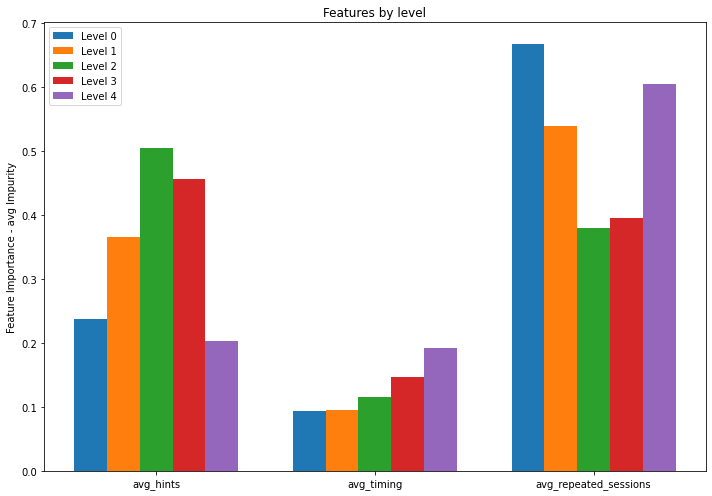

In [61]:
# plot importances by level


labels = features
x = np.arange(len(labels))
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - 2 * (width), lvl0_importances, width, label="Level 0")
rects2 = ax.bar(x - 1 * (width), lvl1_importances, width, label="Level 1")
rects3 = ax.bar(x, lvl2_importances, width, label="Level 2")
rects4 = ax.bar(x + 1 * (width), lvl3_importances, width, label="Level 3")
rects5 = ax.bar(x + 2 * (width), lvl4_importances, width, label="Level 4")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Feature Importance - avg Impurity")
ax.set_title("Features by level")
ax.set_xticks(x, labels)
ax.legend()

# ax.bar_label(rects1, padding=4)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.savefig("feature_importance.png")
plt.show()

In [62]:
# stop our spark instance

spark.stop()

<a id="references"></a>
### References
[Back to top](#top)

Li, R., Singh, J. & Bunk, J. (2018). Technology Tools in Distance Education: A Review of Faculty Adoption. In T. Bastiaens, J. Van Braak, M. Brown, L. Cantoni, M. Castro, R. Christensen, G. Davidson-Shivers, K. DePryck, M. Ebner, M. Fominykh, C. Fulford, S. Hatzipanagos, G. Knezek, K. Kreijns, G. Marks, E. Sointu, E. Korsgaard Sorensen, J. Viteli, J. Voogt, P. Weber, E. Weippl & O. Zawacki-Richter (Eds.), Proceedings of EdMedia: World Conference on Educational Media and Technology (pp. 1982-1987). Amsterdam, Netherlands: Association for the Advancement of Computing in Education (AACE). Retrieved March 27, 2022 from https://www.learntechlib.org/primary/p/184436/.

P. J. Chen, M. E. Hsieh, T. Y. Tsai. Junyi Online Learning Dataset: A large-scale public online learning activity dataset from elementary to senior high school students., 2020. Available from https://www.kaggle.com/datasets/junyiacademy/learning-activity-public-dataset-by-junyi-academy